In [57]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

In [58]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            479 non-null    object 
 1   Player          479 non-null    object 
 2   MatchId         479 non-null    object 
 3   Map             479 non-null    object 
 4   Category        479 non-null    object 
 5   Playlist        479 non-null    object 
 6   Input           479 non-null    object 
 7   Queue           479 non-null    object 
 8   Csr             479 non-null    int64  
 9   Mmr             1 non-null      float64
 10  Outcome         479 non-null    object 
 11  Accuracy        479 non-null    float64
 12  DamageDone      479 non-null    int64  
 13  DamageTaken     479 non-null    int64  
 14  ShotsFired      479 non-null    int64  
 15  ShotsLanded     479 non-null    int64  
 16  ShotsMissed     479 non-null    int64  
 17  KD              479 non-null    flo

In [59]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - (df['ExpectedKills'] / df['ExpectedDeaths'])

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'Csr', 'ShotsFired', 
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides',
                'Perfects', 'Medals',
                'LengthSeconds'],axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 140 to 478
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Map             284 non-null    object 
 1   Outcome         284 non-null    int64  
 2   Accuracy        284 non-null    float64
 3   DamageDone      284 non-null    int64  
 4   DamageTaken     284 non-null    int64  
 5   KD              284 non-null    float64
 6   KDA             284 non-null    float64
 7   Kills           284 non-null    int64  
 8   Deaths          284 non-null    int64  
 9   Assists         284 non-null    int64  
 10  ExpectedKills   284 non-null    float64
 11  ExpectedDeaths  284 non-null    float64
 12  Score           284 non-null    int64  
 13  LengthMinutes   284 non-null    float64
 14  DamageRatio     284 non-null    float64
 15  Damage/Kill     284 non-null    float64
 16  Kills/10Min     284 non-null    float64
 17  Deaths/10Min    284 non-null    f

In [60]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [61]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.465634
DmgT/10Min        0.358186
Deaths            0.341002
KD                0.314351
KDA               0.261587
ExcessDeaths      0.258814
DamageRatio       0.246544
DamageTaken       0.243133
ExpectedDeaths    0.222033
Assists/10Min     0.211898
ExcessKD          0.207623
Damage/Kill       0.135544
LengthMinutes     0.129681
DamageDone        0.102358
Accuracy          0.085530
Kills/10Min       0.079791
Assists           0.070237
Kills             0.041056
ExcessKills       0.036342
ExpectedKills     0.027918
Shots/10Min       0.023868
Score             0.020472
Dmg/10Min         0.013392
Name: Outcome, dtype: float64


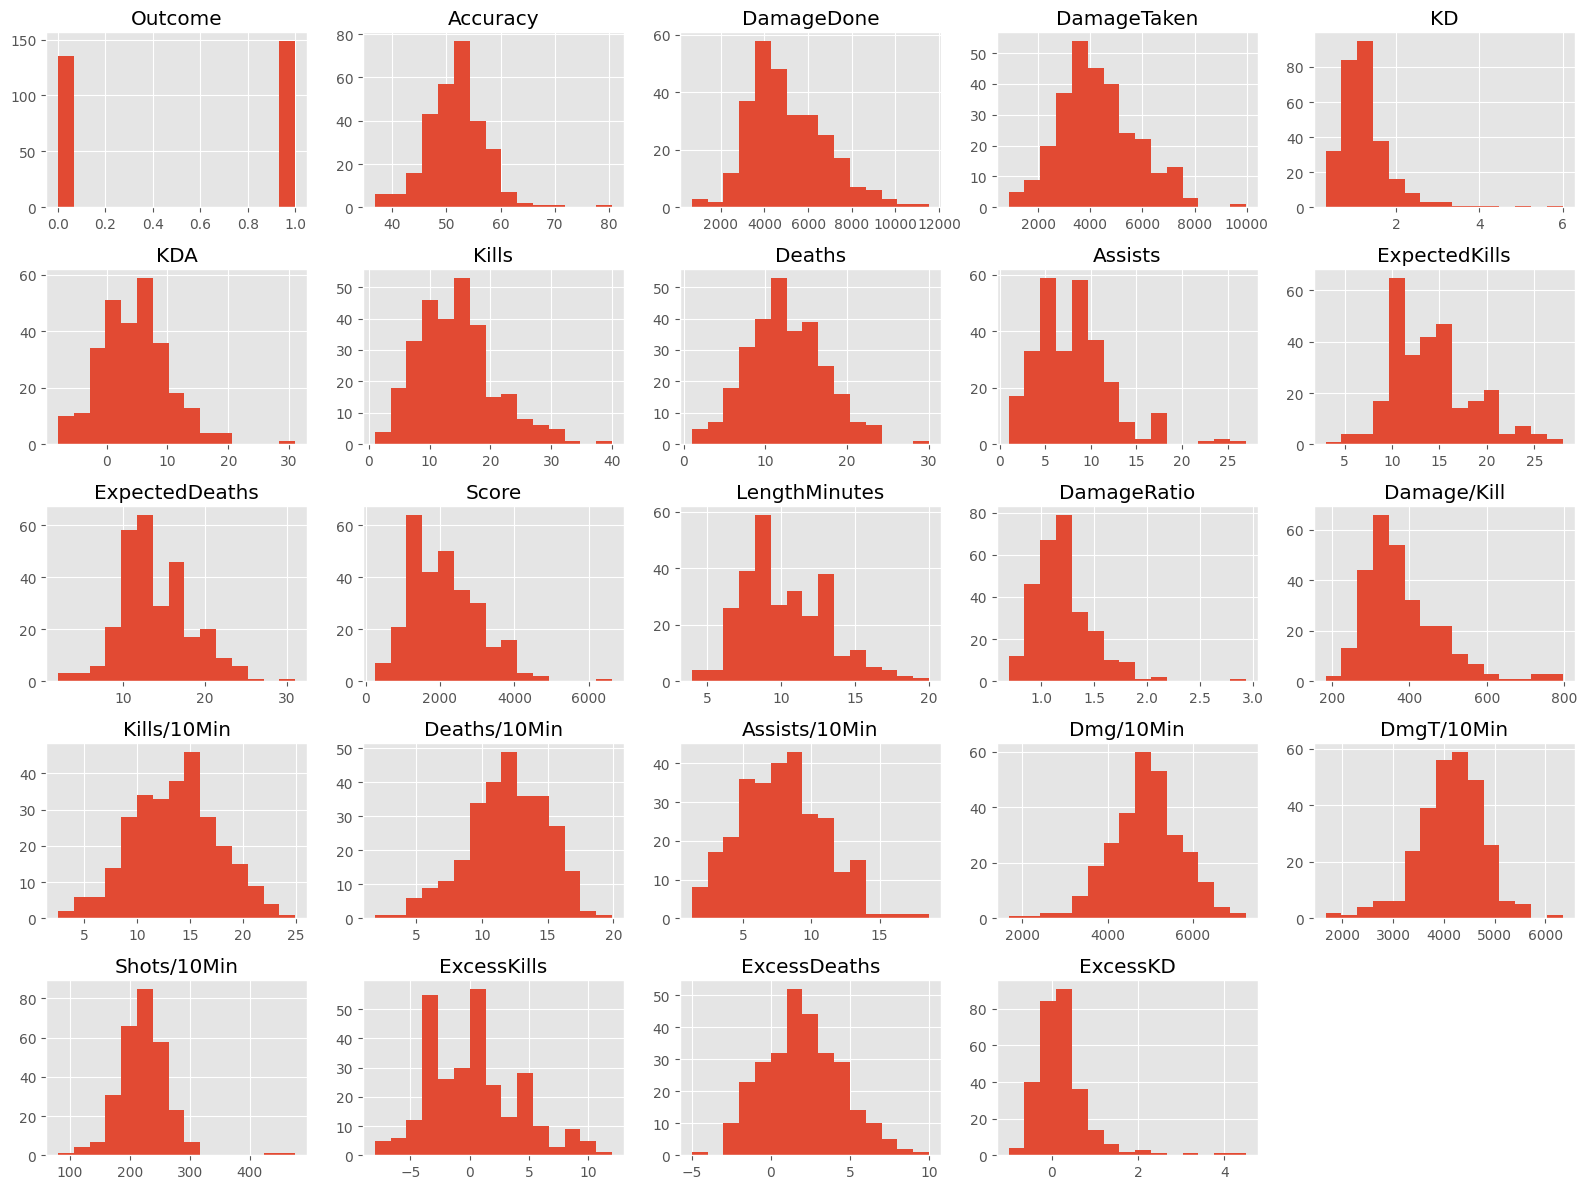

In [62]:
dfRR.hist(bins=15, figsize=(16, 12))
plt.tight_layout()
plt.show()

In [63]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,284.0,0.524648,0.500274,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,284.0,51.782500,5.394910,36.800000,48.527500,51.970000,54.660000,80.560000
DamageDone,284.0,5054.443662,1757.709908,667.000000,3807.500000,4744.500000,6193.250000,11536.000000
DamageTaken,284.0,4299.880282,1464.239170,875.000000,3305.500000,4075.000000,5201.250000,9962.000000
KD,284.0,1.266444,0.674529,0.310000,0.880000,1.160000,1.460000,6.000000
KDA,284.0,4.603627,5.634139,-8.000000,0.915000,4.495000,7.745000,31.000000
Kills,284.0,14.288732,6.369185,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,284.0,12.369718,4.807304,1.000000,9.000000,12.000000,16.000000,30.000000
Assists,284.0,8.059859,4.131232,1.000000,5.000000,7.500000,10.000000,27.000000
ExpectedKills,284.0,14.088028,4.330351,3.000000,11.000000,13.000000,16.000000,28.000000


In [64]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [65]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (284, 24)
Y Shape: (284,)


In [66]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')

X Train Shape: (227, 24)
X Test Shape: (57, 24)


In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['KD', 'KDA', 'Kills', 'Deaths', 'Assists', 'DamageDone', 'DamageTaken', 'DamageRatio', 
                                   'Damage/Kill', 'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min', 'DmgT/10Min',
                                   'ExcessKills', 'ExcessDeaths', 'ExcessKD', 'ExpectedKills', 'ExpectedDeaths', 'Score', 'Shots/10Min']),
        ('cat', OneHotEncoder(), ['Map'])
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:20], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

## Logistic Regression

In [69]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))

Unregularized Logistic Regression Accuracy: 0.8070175438596491
Acc: 0.807
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.23
OOS R^2 Score: 0.23



## Ridge

In [70]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
ridge_cv.cv_results_
paramResults(ridge_cv)

LogisticRegression(C=100, solver='saga')
Ridge Accuracy: 0.8070175438596491
   C_param  Accuracy
0    0.001  0.634300
1    0.010  0.678744
2    0.100  0.744928
3    1.000  0.766763
4   10.000  0.766763
5  100.000  0.771208


''

In [71]:
ResultsOut(ridge_cv)

Acc: 0.807
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.23
OOS R^2 Score: 0.23


''

## Lasso

In [72]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
lasso_cv.cv_results_
paramResults(lasso_cv)


LogisticRegression(C=1, penalty='l1', solver='saga')
Lasso Accuracy: 0.8070175438596491
   C_param  Accuracy
0    0.001  0.524348
1    0.010  0.519710
2    0.100  0.696329
3    1.000  0.775749
4   10.000  0.766763
5  100.000  0.771208


''

In [73]:
ResultsOut(lasso_cv)

Acc: 0.807
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.23
OOS R^2 Score: 0.23


''

## ElasticNet

In [74]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
elastic_cv.cv_results_
paramResults(elastic_cv)

LogisticRegression(C=1, l1_ratio=0.75, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8070175438596491
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.519710
1     0.001            0.50  0.533043
2     0.001            0.75  0.511014
3     0.010            0.25  0.625797
4     0.010            0.50  0.533043
5     0.010            0.75  0.533043
6     0.100            0.25  0.709855
7     0.100            0.50  0.687633
8     0.100            0.75  0.678841
9     1.000            0.25  0.762415
10    1.000            0.50  0.762415
11    1.000            0.75  0.775652
12   10.000            0.25  0.766763
13   10.000            0.50  0.766763
14   10.000            0.75  0.766763
15  100.000            0.25  0.771208
16  100.000            0.50  0.771208
17  100.000            0.75  0.771208


''

In [75]:
ResultsOut(elastic_cv)

Acc: 0.807
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.23
OOS R^2 Score: 0.23


''

## K-Nearest Neighbours

In [76]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
paramResults(knn_cv)

KNeighborsClassifier(n_neighbors=43)
K-Nearest Neighbors Accuracy: 0.7192982456140351
    n_neighbors_param  Accuracy
0                   1  0.661256
1                   4  0.687440
2                   7  0.665217
3                  10  0.683092
4                  13  0.674300
5                  16  0.678937
6                  19  0.670048
7                  22  0.683285
8                  25  0.692174
9                  28  0.683285
10                 31  0.678744
11                 34  0.696522
12                 37  0.696425
13                 40  0.691884
14                 43  0.700483
15                 46  0.691884
16                 49  0.691594


''

In [77]:
ResultsOut(knn_cv)

Acc: 0.719
MAE: 0.28
MSE: 0.28
RMSE: 0.53
R^2 Score: -0.12
OOS R^2 Score: -0.12


''

## Random Forest

In [78]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=15, n_estimators=300, random_state=69)
Random Forest Accuracy: 0.7192982456140351
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.687246
1               10                 300  0.709469
2               10                 500  0.713913
3               15                 100  0.700483
4               15                 300  0.718261
5               15                 500  0.718261
6               20                 100  0.700483
7               20                 300  0.718261
8               20                 500  0.718261


''

In [79]:
ResultsOut(rf_cv)

Acc: 0.719
MAE: 0.28
MSE: 0.28
RMSE: 0.53
R^2 Score: -0.12
OOS R^2 Score: -0.12


''

<AxesSubplot: >

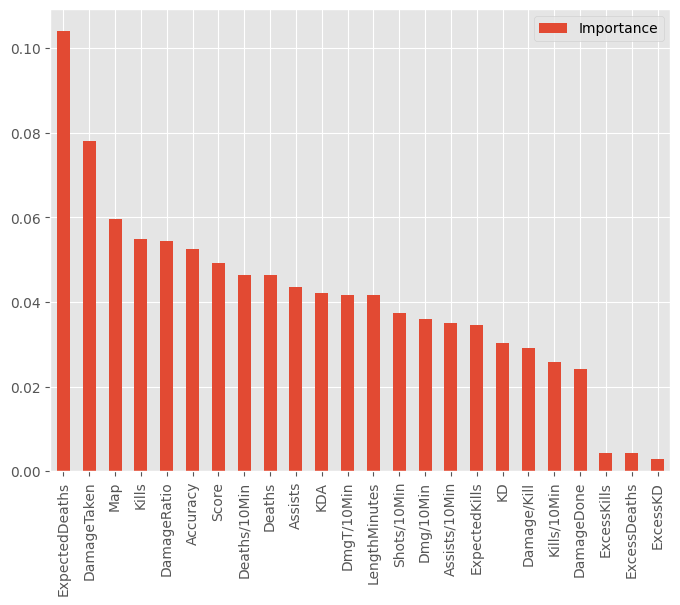

In [80]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [81]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(max_depth=6, n_estimators=500, random_state=69,
                           subsample=0.5)
Gradient Boosed Trees Accuracy: 0.7192982456140351
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              1.0   
2                  0.01                2                 300              0.5   
3                  0.01                2                 300              1.0   
4                  0.01                2                 500              0.5   
5                  0.01                2                 500              1.0   
6                  0.01                4                 100              0.5   
7                  0.01                4                 100              1.0   
8                  0.01                4                 300              0.5   
9                  0.0

''

In [82]:
ResultsOut(GBRT)

Acc: 0.719
MAE: 0.28
MSE: 0.28
RMSE: 0.53
R^2 Score: -0.12
OOS R^2 Score: -0.12


''

<AxesSubplot: >

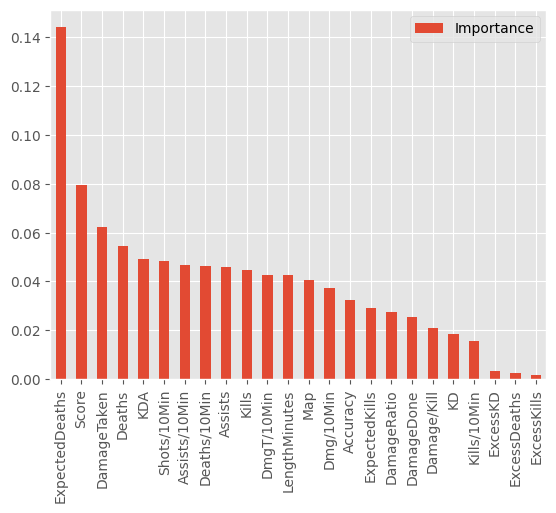

In [83]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [93]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=450, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.6842105263157895
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.700483
1                 0.001                1                 450  0.700483
2   

''

In [94]:
ResultsOut(XGB)

Acc: 0.684
MAE: 0.32
MSE: 0.32
RMSE: 0.56
R^2 Score: -0.26
OOS R^2 Score: -0.25


''

<AxesSubplot: >

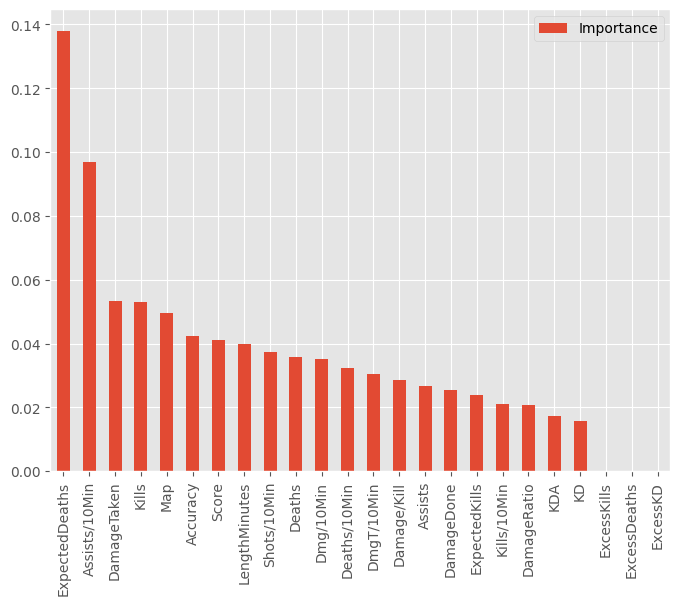

In [95]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

,Model,ACC,MAE,MSE,RMSE,R2,OOS R2
0,Logistic Regression,0.807,0.193,0.193,0.439,0.228,0.233
1,Ridge,0.807,0.193,0.193,0.439,0.228,0.233
2,Lasso,0.807,0.193,0.193,0.439,0.228,0.233
3,ElasticNet,0.807,0.193,0.193,0.439,0.228,0.233
4,K-Nearest Neighbors,0.719,0.281,0.281,0.530,-0.123,-0.115
5,Random Forest,0.719,0.281,0.281,0.530,-0.123,-0.115
6,Gradient Boosted Trees,0.719,0.281,0.281,0.530,-0.123,-0.115
7,XGBoost,0.684,0.316,0.316,0.562,-0.264,-0.255


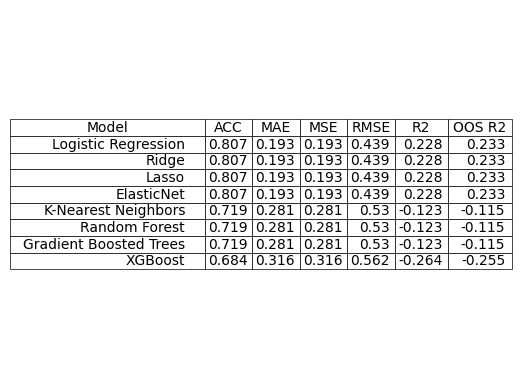

In [96]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('Model Results11282023.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)